<a href="https://colab.research.google.com/github/jrg94/CSE5522/blob/lab4/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron Learning

**Overview**

The perceptron learning rule is a simple method for training a linear classifier.

The basic idea is: when you classify something incorrectly, move the linear classifier a bit in a way that updates the boundary line.  This is related to the gradient descent algorithm used for linear regression.

In the first part of the exercise, you will learn the "and" function to show the basic operation of the PLR, and in the second you'll try to classify some vowels.

There is an optional part to play around with PyTorch, a toolkit that can be used to quickly learn neural networks.  I'll provide a quick walkthrough for learning the XOR problem (based on some code from U. Washington); see if you can adapt this to the vowel classification problem.

Note: you may want to change your runtime type to GPU/TPU to speed up computation if you go to PyTorch.



## **Part 1**

In the first part of the hands-on, you'll code the Perceptron Learning Rule (PLR) algorithm.

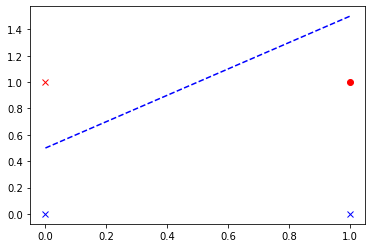

In [524]:
# set up some preliminaries

import numpy as np
import matplotlib.pyplot as plt

# set classification data for "and"
data=np.array([[0,0],[0,1],[1,0],[1,1]])
targets=np.array([0,0,0,1])
bias=-1

# set some initial weights : w1, w2, bias
weights_init=np.array([-1,1,0.5])

# here is a function for plotting both the dataset and the current decision
# boundary, with errors in red
def plotgraph(data,targets,weights):
  classification=(np.sign(np.dot(np.hstack((data,np.ones((data.shape[0],1))*bias)),weights))+1)/2

  plt.plot(data[np.logical_and(targets==1,classification==1),0],
           data[np.logical_and(targets==1,classification==1),1],'bo')
  plt.plot(data[np.logical_and(targets==1,classification==0),0],
           data[np.logical_and(targets==1,classification==0),1],'ro')
  plt.plot(data[np.logical_and(targets==0,classification==1),0],
           data[np.logical_and(targets==0,classification==1),1],'rx')
  plt.plot(data[np.logical_and(targets==0,classification==0),0],
           data[np.logical_and(targets==0,classification==0),1],'bx')

  # note weights are in form w_1*x + w_2*y + w_b = 0
  # so to plot line we need y= -(w_1*x + w_b)/(w_2)
  dmin=np.min(data[:,0])
  dmax=np.max(data[:,0])
  plt.plot(np.array([dmin,dmax]),
           np.array([-(dmin*weights[0]+weights[2]*bias)/(weights[1]),
                     -(dmax*weights[0]+weights[2]*bias)/(weights[1])]),
           'b--'
           )


#Plot the current situation.  Red items are misclassified, blue
#correctly classified. x=0, circle=1.
plotgraph(data,targets,weights_init)


**1.1** This is where you will need to code the perceptron learning algorithm.

You should assume that the nonlinear function is a step function that outputs 1 if the input is greater than 0, and 0 otherwise.

Note that I had a sign bug in the slides.  The error should be the difference between the output and target (i.e. if output is 1 and target is 0, the error is 1).  

Remember that there should be a bias.  You can choose to define the fixed bias as -1 (as traditionally done) or 1.  Note if you change the bias you may need to pay attention to the plotting function above.

The function should return the updated weight vector.  

In [0]:
def plr(weights, example, target, learningrate):
  # compute weight update
  # return updated weights
  example_with_bias = np.append(example, bias)
  # weights[0] * example[0] + weights[1] * example[1] + weights[2] * bias
  g = np.sum(weights * example_with_bias)
  output = 1 if g > 0 else 0
  error = output - target
  return weights - learningrate * error * example_with_bias

**1.2** The following function will randomize your training examples, and run the PLR for each example.

In [0]:
def run_epoch(weights, data, targets, learningrate):
  nexamples=data.shape[0]
  order=np.random.permutation(nexamples)
  for i in range(nexamples):
    weights=plr(weights,data[order[i]],targets[order[i]],learningrate)
  return weights

**1.3** Now write a bit of code to run through epochs until convergence.

In [527]:
print(data)

[[0 0]
 [0 1]
 [1 0]
 [1 1]]


In [0]:
def experiment(iterations, weights, data, targets, learningrate):
  for _ in range(iterations):
    weights = run_epoch(weights, data, targets, learningrate)
  return weights

In [529]:
# write code to run through convergence
# put final weights into "finalweights"
LEARNING_RATE = .0111
ITERS = 10000
finalweights = experiment(ITERS, weights_init, data, targets, LEARNING_RATE)
print(finalweights)

[0.0212 0.7447 0.7553]


**1.4** Plot the final weights to show the boundary that you have learned.

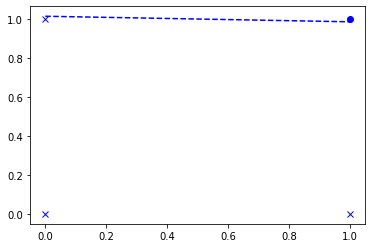

In [530]:
plotgraph(data,targets,finalweights)

**1.5** Optional extensions:

**1.5.1** Rerun your code for the "or" function.

**1.5.2** Modify your code to allow for the majority class function for three inputs (i.e. 1 if 2 or more inputs are on).

**1.5.3** Investigate what happens if you run the "xor" function through the training.


## **Part 2: Vowel Classification**

In this section, you will look at some actual (noisy) vowel formant data.  Go to the International Phonetic Alphabet (IPA) vowel chart at https://en.wikipedia.org/wiki/IPA_vowel_chart_with_audio and play the sounds.  The chart is written in IPA, but here are the two letter (ARPABET) symbols for some of the vowels of English:

* iy: close front unrounded
* ih: near-close front unrounded
* ey: close-mid front unrounded
* eh: open-mid front unrounded
* ah: open back rounded
* ao: open-mid back rounded
* ow: close-mid back rounded
* uw: close back rounded
* ax: mid central unrounded

I've prepared a csv datafile with the following features:

* f1, f2: formants
* h1: close
* h2: near-close or higher
* h3: close-mid or higher
* h4: mid or higher
* h5: open-mid or higher
* b1: back
* b2: central or back
* r: rounded

First, let's read in the data.



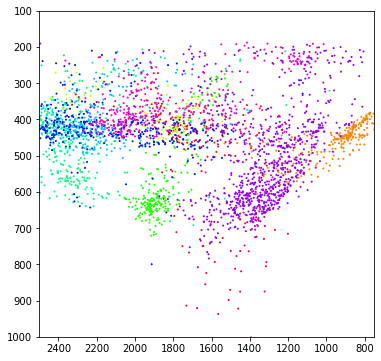

In [531]:
# first, read in the data and build a scatterplot showing the vowel formants
import pandas as pd
url='https://raw.githubusercontent.com/efosler/cse5522data/master/vowelfmts.csv'
df=pd.read_csv(url)

# This function will plot the vowels as a scatterplot with different colors
# using the traditional F2 vs F1 inverted plot.  This puts high (close) vowels
# at the top of the plot and low vowels (open) at the bottom.  Front vowels
# are to the left; back vowels to the right.  Optionally can plot a boundary.

def plotvowels(df,weights=None):
  # this next bit converts the label into a colormap value between 0 and 1
  vowels=df['vowel'].unique()
  vmap={}
  for i in range(vowels.shape[0]):
    vmap[vowels[i]]=float(i)/float(vowels.shape[0]-1)
  df['color']=df['vowel'].map(vmap)
  # plot the scatterplot
  plt.figure(num=1,figsize=(6,6))
  plt.scatter(df['f2'],df['f1'],s=1,c=df['color'],cmap='gist_rainbow')
  plt.gca().set_ylim([100,1000])
  plt.gca().set_xlim([750,2500])
  plt.gca().invert_xaxis()
  plt.gca().invert_yaxis()
  if weights is not None:
    dmin=df['f2'].min()
    dmax=df['f2'].max()
    plt.plot(np.array([dmin,dmax]),
             np.array([-(dmin*weights[0]+weights[2])/(weights[1]),
                       -(dmax*weights[0]+weights[2])/(weights[1])]),
             'b--'
             )

# Plot the vowel data.  Compare against the IPA chart online.      
plotvowels(df)

You will notice that the vowel classes aren't linearly separable.  The idea will be to try to separate the different kinds of vowels (back/front/close/open) with different separators.

**2.2** A bit of code to create training/test sets.

In [0]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(df[['f1','f2']],df[['close','near-close+','close-mid+','mid+','open-mid+','back','central-or-back','rounded','vowel']])

**2.3** At this point, the project becomes a bit open-ended and exploratory.  What you should do is normalize F1 and F2 (perhaps it would be best to do that before the data splits, but that is your choice).  The main reason is that the bias term needs to be pretty high.

Try to predict one of the targets (e.g. train_targets['central-or-back']) from the f2/f1 data.  If you can get reasonable classifiers for the 8 vowel features (h1-h5,b1,b2,r) then see if you can predict the vowel category based on the output of the classifiers.  

WARNING: since your classes will not be linearly separable, you will need to NOT run to convergence (as they won't converge).  See if you can figure out a reasonable place to stop training.

If you get stuck on this point, and want to try something different, move on to Part 3.

In [533]:
# normalize training data (borrowed from https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame)
from sklearn import preprocessing
x = train_data.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_data = pd.DataFrame(x_scaled)
print(train_data)

             0         1
0     0.225211  0.747851
1     0.148429  0.800838
2     0.312225  0.332858
3     0.194189  0.731647
4     0.274631  0.232307
...        ...       ...
2422  0.159025  0.683687
2423  0.384561  0.365520
2424  0.294408  0.190656
2425  0.253253  0.235486
2426  0.338552  0.556131

[2427 rows x 2 columns]


In [534]:
print(train_targets.columns)

Index(['close', 'near-close+', 'close-mid+', 'mid+', 'open-mid+', 'back',
       'central-or-back', 'rounded', 'vowel'],
      dtype='object')


In [535]:
# predict one of the attributes from training data
ITER = 100
close_weights = experiment(ITER, weights_init, train_data.values, train_targets["close"].values, LEARNING_RATE)
near_close_weights = experiment(ITER, weights_init, train_data.values, train_targets["near-close+"].values, LEARNING_RATE)
close_mid_weights = experiment(ITER, weights_init, train_data.values, train_targets["close-mid+"].values, LEARNING_RATE)
mid_weights = experiment(ITER, weights_init, train_data.values, train_targets["mid+"].values, LEARNING_RATE)
open_mid_weights = experiment(ITER, weights_init, train_data.values, train_targets["open-mid+"].values, LEARNING_RATE)
back_weights = experiment(ITER, weights_init, train_data.values, train_targets["back"].values, LEARNING_RATE)
central_or_back_weights = experiment(ITER, weights_init, train_data.values, train_targets["central-or-back"].values, LEARNING_RATE)
rounded_weights = experiment(ITER, weights_init, train_data.values, train_targets["rounded"].values, LEARNING_RATE)

display(
    close_weights,
    near_close_weights,
    close_mid_weights,
    mid_weights,
    open_mid_weights,
    back_weights,
    central_or_back_weights,
    rounded_weights
)

array([-0.05647002,  0.00477776,  0.0005    ])

array([-0.05641488,  0.02757013,  0.0005    ])

array([-0.03363274,  0.00991045, -0.0106    ])

array([-0.02814124,  0.01484754, -0.0106    ])

array([-0.02421403, -0.00016553, -0.0106    ])

array([-0.00549411, -0.06258195, -0.0328    ])

array([-0.00961085, -0.0542409 , -0.0439    ])

array([-0.00964819, -0.05077127, -0.0328    ])

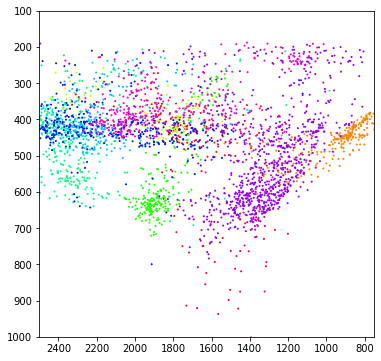

In [536]:
plotvowels(df, close_weights)

In [0]:
# if you get this far, take the classifiers and try to predict vowel class ("and" function)!

## **Part 3: PyTorch Neural Networks**

This is a quick runthrough of PyTorch, and how to build a neural network.  The code below is a modified version of https://courses.cs.washington.edu/courses/cse446/18wi/sections/section8/XOR-Pytorch.html with some additional annotations to help you along.

This part is mostly read-and-run, but at the end you can test your understanding by modifying the code.

**3.1** First some library preliminaries.

In [538]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(2)

**3.2** Now set up the data into *tensors* (i.e. multidimensional arrays).  X is the data array, Y is the target.

In [0]:
X = torch.Tensor([[0,0],[0,1], [1,0], [1,1]])
Y = torch.Tensor([0,1,1,0]).view(-1,1)

**3.3** Let's define a multi-layer perceptron with 2 layers.  Each layer will create a linear combination of the inputs, and feed to a sigmoid output.

Note that the initializer (with the calls to nn.Linear) will create a set of parameters that are associated with the model.

In [0]:
class MLP2(nn.Module):
    def __init__(self, input_dim = 2, hid_dim=2, output_dim=1):
        # initialze the superclass
        super(MLP2, self).__init__()
        # this will create a linear layer with input_dim x hid_dim parameters
        # in addition to a bias unit with hid_dim parameters
        self.lin1 = nn.Linear(input_dim, hid_dim)
        # same thing here except hid_dim x output_dim
        self.lin2 = nn.Linear(hid_dim, output_dim)
    
    # this is where the meat of the action is
    def forward(self, x):
        x = self.lin1(x)  # linear combination of inputs
        x = torch.sigmoid(x) # then through sigmoid - output of first layer
        x = self.lin2(x) # linear combination of hidden units
        x = torch.sigmoid(x) # then through sigmoid - net output
        return x

**3.4** We also define a function to initialize weights of our model.

In [0]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # initialize the weight tensor, here we use a normal distribution
            m.weight.data.normal_(0, 1)

**3.5** Now create a model and initialize it.  Also define a loss function and the optimizer.

In [0]:
model1 = MLP2()
weights_init(model1)
loss_func = nn.MSELoss()
optimizer = optim.SGD(model1.parameters(), lr=0.02, momentum=0.9)

**3.6** Now we run the training.

In [543]:
epochs = 5001
steps = X.size(0)
for i in range(epochs):
    for j in range(steps):
        data_point = np.random.randint(X.size(0))
        x_var = Variable(X[data_point], requires_grad=False)
        y_var = Variable(Y[data_point], requires_grad=False)
        
        optimizer.zero_grad()
        y_hat = model1(x_var)
        loss = loss_func.forward(y_hat, y_var)
        loss.backward()
        optimizer.step()

    if i % 500 == 0:
        print("Epoch: {0}, Loss: {1}, ".format(i, loss.data.numpy()))

Epoch: 0, Loss: 0.546196699142456, 
Epoch: 500, Loss: 0.28376320004463196, 
Epoch: 1000, Loss: 0.013824088498950005, 
Epoch: 1500, Loss: 0.18451432883739471, 
Epoch: 2000, Loss: 0.003591624554246664, 
Epoch: 2500, Loss: 0.30507779121398926, 
Epoch: 3000, Loss: 0.22130440175533295, 
Epoch: 3500, Loss: 0.0009261174127459526, 
Epoch: 4000, Loss: 0.0015603675274178386, 
Epoch: 4500, Loss: 0.2250307947397232, 
Epoch: 5000, Loss: 0.19259676337242126, 


**3.7** This is a neat little bit of code that will print out the first layer's decision boundaries.

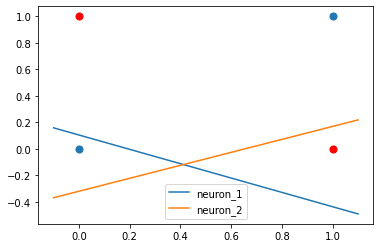

In [544]:
model_params = list(model1.parameters())
model_weights = model_params[0].data.numpy()
model_bias = model_params[1].data.numpy()

plt.scatter(X.numpy()[[0,-1], 0], X.numpy()[[0, -1], 1], s=50)
plt.scatter(X.numpy()[[1,2], 0], X.numpy()[[1, 2], 1], c='red', s=50)

x_1 = np.arange(-0.1, 1.1, 0.1)
y_1 = ((x_1 * model_weights[0,0]) + model_bias[0]) / (-model_weights[0,1])
plt.plot(x_1, y_1)

x_2 = np.arange(-0.1, 1.1, 0.1)
y_2 = ((x_2 * model_weights[1,0]) + model_bias[1]) / (-model_weights[1,1])
plt.plot(x_2, y_2)
plt.legend(["neuron_1", "neuron_2"], loc=8)
plt.show()

**3.8** Now take a look at the parameters that were learned.  Can you trace how the xor decision works for each of the datapoints?  

The first tensor is the input-hidden weights, second is the bias-hidden weights, third is hidden-output, and last is bias-output.

In [545]:
model_params

[Parameter containing:
 tensor([[-4.1356, -7.6377],
         [-3.8804,  7.9293]], requires_grad=True), Parameter containing:
 tensor([0.7887, 2.5462], requires_grad=True), Parameter containing:
 tensor([[-5.7379, -4.6766]], requires_grad=True), Parameter containing:
 tensor([4.4224], requires_grad=True)]

**3.9** Can you modify the above code to add a third layer?  What happens if you replace the sigmoid in the middle layer(s) with tanh?

To do this, I modified the constructor to include another linear layer. 

In [0]:
class MLP3(nn.Module):
    def __init__(self, input_dim = 2, hid_dim=2, output_dim=1):
        # initialze the superclass
        super(MLP3, self).__init__()
        # this will create a linear layer with input_dim x hid_dim parameters
        # in addition to a bias unit with hid_dim parameters
        self.lin1 = nn.Linear(input_dim, hid_dim)
        # a hidden layer between input layer and output layer
        self.lin_hid = nn.Linear(hid_dim, hid_dim)
        # same thing here except hid_dim x output_dim
        self.lin2 = nn.Linear(hid_dim, output_dim)
    
    # this is where the meat of the action is
    def forward(self, x):
        x = self.lin1(x)  # linear combination of inputs
        x = torch.sigmoid(x) # then through sigmoid - output of first layer
        x = self.lin_hid(x)
        x = torch.sigmoid(x)
        x = self.lin2(x) # linear combination of hidden units
        x = torch.sigmoid(x) # then through sigmoid - net output
        return x

In [0]:
model2 = MLP3()
weights_init(model2)
loss_func = nn.MSELoss()
optimizer = optim.SGD(model2.parameters(), lr=0.02, momentum=0.9)

In [548]:
epochs = 5001
steps = X.size(0)
for i in range(epochs):
    for j in range(steps):
        data_point = np.random.randint(X.size(0))
        x_var = Variable(X[data_point], requires_grad=False)
        y_var = Variable(Y[data_point], requires_grad=False)
        
        optimizer.zero_grad()
        y_hat = model2(x_var)
        loss = loss_func.forward(y_hat, y_var)
        loss.backward()
        optimizer.step()

    if i % 500 == 0:
        print("Epoch: {0}, Loss: {1}, ".format(i, loss.data.numpy()))

Epoch: 0, Loss: 0.35206159949302673, 
Epoch: 500, Loss: 0.18619056046009064, 
Epoch: 1000, Loss: 0.18661904335021973, 
Epoch: 1500, Loss: 0.2543376088142395, 
Epoch: 2000, Loss: 0.32545801997184753, 
Epoch: 2500, Loss: 0.044899385422468185, 
Epoch: 3000, Loss: 0.0037707574665546417, 
Epoch: 3500, Loss: 0.002102543832734227, 
Epoch: 4000, Loss: 0.0009307260625064373, 
Epoch: 4500, Loss: 0.0009499363950453699, 
Epoch: 5000, Loss: 0.0007285471656359732, 


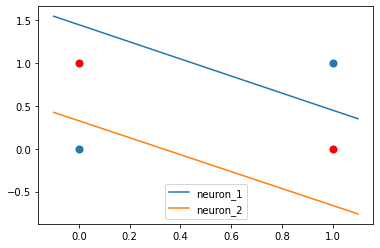

In [549]:
model_params = list(model2.parameters())
model_weights = model_params[0].data.numpy()
model_bias = model_params[1].data.numpy()

plt.scatter(X.numpy()[[0,-1], 0], X.numpy()[[0, -1], 1], s=50)
plt.scatter(X.numpy()[[1,2], 0], X.numpy()[[1, 2], 1], c='red', s=50)

x_1 = np.arange(-0.1, 1.1, 0.1)
y_1 = ((x_1 * model_weights[0,0]) + model_bias[0]) / (-model_weights[0,1])
plt.plot(x_1, y_1)

x_2 = np.arange(-0.1, 1.1, 0.1)
y_2 = ((x_2 * model_weights[1,0]) + model_bias[1]) / (-model_weights[1,1])
plt.plot(x_2, y_2)
plt.legend(["neuron_1", "neuron_2"], loc=8)
plt.show()

I have executed these models a few times, and I continue to get different results. However, in general, the second model (model2) draws better decision boundaries (although it doesn't always converge on the proper boundaries): each line separates a different point of the same color in parallel. Meanwhile, the first model (model1) gets confused around the decision boundaries. For example, one line separates off a blue point while the other line separates off an orange point—both lines cross in the middle.

If I increase the epochs, I don't really see a difference. The first model (model1) still fails to get the right decision boundaries. That said, the second model (model2) does almost certainly converge with more epochs. 

At any rate, the following model introduces tanh into the new middle layer:

In [0]:
class MLP4(nn.Module):
    def __init__(self, input_dim = 2, hid_dim=2, output_dim=1):
        # initialze the superclass
        super(MLP4, self).__init__()
        # this will create a linear layer with input_dim x hid_dim parameters
        # in addition to a bias unit with hid_dim parameters
        self.lin1 = nn.Linear(input_dim, hid_dim)
        # a hidden layer between input layer and output layer
        self.lin_hid = nn.Linear(hid_dim, hid_dim)
        # same thing here except hid_dim x output_dim
        self.lin2 = nn.Linear(hid_dim, output_dim)
    
    # this is where the meat of the action is
    def forward(self, x):
        x = self.lin1(x)  # linear combination of inputs
        x = torch.sigmoid(x) # then through sigmoid - output of first layer
        x = self.lin_hid(x)
        x = torch.tanh(x)
        x = self.lin2(x) # linear combination of hidden units
        x = torch.sigmoid(x) # then through sigmoid - net output
        return x

In [0]:
model3 = MLP4()
weights_init(model3)
loss_func = nn.MSELoss()
optimizer = optim.SGD(model3.parameters(), lr=0.02, momentum=0.9)

In [552]:
epochs = 5001
steps = X.size(0)
for i in range(epochs):
    for j in range(steps):
        data_point = np.random.randint(X.size(0))
        x_var = Variable(X[data_point], requires_grad=False)
        y_var = Variable(Y[data_point], requires_grad=False)
        
        optimizer.zero_grad()
        y_hat = model3(x_var)
        loss = loss_func.forward(y_hat, y_var)
        loss.backward()
        optimizer.step()

    if i % 500 == 0:
        print("Epoch: {0}, Loss: {1}, ".format(i, loss.data.numpy()))

Epoch: 0, Loss: 0.24193350970745087, 
Epoch: 500, Loss: 0.36526626348495483, 
Epoch: 1000, Loss: 0.00633761752396822, 
Epoch: 1500, Loss: 0.007188642863184214, 
Epoch: 2000, Loss: 0.002022228669375181, 
Epoch: 2500, Loss: 0.00030018037068657577, 
Epoch: 3000, Loss: 0.00032175323576666415, 
Epoch: 3500, Loss: 0.00044414607691578567, 
Epoch: 4000, Loss: 0.00016753435193095356, 
Epoch: 4500, Loss: 5.7184424804290757e-05, 
Epoch: 5000, Loss: 0.0002461254480294883, 


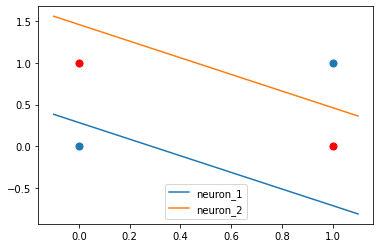

In [553]:
model_params = list(model3.parameters())
model_weights = model_params[0].data.numpy()
model_bias = model_params[1].data.numpy()

plt.scatter(X.numpy()[[0,-1], 0], X.numpy()[[0, -1], 1], s=50)
plt.scatter(X.numpy()[[1,2], 0], X.numpy()[[1, 2], 1], c='red', s=50)

x_1 = np.arange(-0.1, 1.1, 0.1)
y_1 = ((x_1 * model_weights[0,0]) + model_bias[0]) / (-model_weights[0,1])
plt.plot(x_1, y_1)

x_2 = np.arange(-0.1, 1.1, 0.1)
y_2 = ((x_2 * model_weights[1,0]) + model_bias[1]) / (-model_weights[1,1])
plt.plot(x_2, y_2)
plt.legend(["neuron_1", "neuron_2"], loc=8)
plt.show()

The only difference I can see between this new model with tanh as the activation function is that the two lines swapped places (i.e. orange is the top decision boundary while blue is the bottom decision boundary). It also seems to have converged slightly faster. 

## **Part 4: MLP classification of vowels**

If you've gotten this far, then here is a challenge for you.  Taking the data from Part 2, can you build a MLP that can classify the vowels directly into vowel classes?

You should have a hidden layer with a reasonable number of hidden units (maybe 100), and your output should be a softmax layer with 9 outputs (one for each vowel class). The target should be 1 for the correct class, and 0 otherwise. The loss function should also be changed to a Cross Entropy loss.  You may need to do a bit of googling of "pytorch ___" to find the different kinds of functions you need.

**4.1**: Let's setup some code for training a vowel classification model.

In [0]:
class MLPVowel(nn.Module):
    def __init__(self, input_dim = 2, hid_dim=100, output_dim=9):
        super(MLPVowel, self).__init__()
        
        self.lin1 = nn.Linear(input_dim, hid_dim)
        self.lin2 = nn.Linear(hid_dim, output_dim)
    
    # this is where the meat of the action is
    def forward(self, x):
        x = self.lin1(x)  # linear combination of inputs
        x = torch.sigmoid(x) # then through sigmoid - output of first layer
        x = self.lin2(x) # linear combination of hidden units
        x = torch.sigmoid(x) # then through sigmoid - net output
        return x

In [0]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # initialize the weight tensor, here we use a normal distribution
            m.weight.data.normal_(0, 1)

In [0]:
def get_tensors(data, targets):
  # Normalize test data
  x = data.values 
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  normal_x = pd.DataFrame(x_scaled)

  # Convert test data to categorical values
  vowels = targets['vowel'].astype('category').cat.codes # I fear this isn't returning the same thing for both test and train data....

  # Setup tensors
  X = torch.Tensor(normal_x.values)
  Y = torch.Tensor(vowels.values).long().view(-1, 1)
  return X, Y

In [0]:
# Define data and convert it into useful tensors
train_data, test_data, train_targets, test_targets = train_test_split(df[['f1','f2']],df[['close','near-close+','close-mid+','mid+','open-mid+','back','central-or-back','rounded','vowel']])
train_x, train_y = get_tensors(train_data, train_targets)
test_x, test_y = get_tensors(test_data, test_targets)

In [0]:
# Initialize model
vowel_model = MLPVowel()
weights_init(vowel_model)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(vowel_model.parameters(), lr=0.02, momentum=0.9)

In [559]:
# Train model
epochs = 101
steps = train_x.size(0)
for i in range(epochs):
    for j in range(steps):
        data_point = np.random.randint(X.size(0))
        x_var = Variable(train_x[data_point], requires_grad=False)
        y_var = Variable(train_y[data_point], requires_grad=False)
        
        optimizer.zero_grad()
        y_hat = vowel_model(x_var).view(1, -1)
        loss = loss_func.forward(y_hat, y_var)
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print("Epoch: {0}, Loss: {1}, ".format(i, loss.data.numpy()))

Epoch: 0, Loss: 1.867920160293579, 
Epoch: 10, Loss: 1.6709479093551636, 
Epoch: 20, Loss: 1.523019552230835, 
Epoch: 30, Loss: 1.5222846269607544, 
Epoch: 40, Loss: 1.5210046768188477, 
Epoch: 50, Loss: 1.3725100755691528, 
Epoch: 60, Loss: 1.5210357904434204, 
Epoch: 70, Loss: 1.3722891807556152, 
Epoch: 80, Loss: 1.5209078788757324, 
Epoch: 90, Loss: 1.5209619998931885, 
Epoch: 100, Loss: 1.5208423137664795, 


**4.2** With the model trained, let's try testing its performance.

In [560]:
# Test performance
total = 0
correct = 0
steps = test_x.size(0)
for i in range(steps):
  x_var = test_x[i]
  y_var = test_y[i]
  y_hat = vowel_model(x_var).view(1, -1)
  # Borrowed from docs: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
  _, predicted = torch.max(y_hat.data, 1)
  total += 1
  correct += 1 if y_var == predicted else 0

print(correct/total)

0.18888888888888888


Also, let's get this performance code into a reusable function:

In [0]:
def performance(x, y, model):
  # Run experiment
  total = 0
  correct = 0
  steps = x.size(0)
  for i in range(steps):
    x_var = x[i]
    y_var = y[i]
    y_hat = model(x_var).view(1, -1)
    # Borrowed from docs: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    _, predicted = torch.max(y_hat.data, 1)
    total += 1
    correct += 1 if y_var == predicted else 0
  
  print(correct/total)

In [562]:
performance(test_x, test_y, vowel_model)

0.18888888888888888


**4.3** Unfortunately, this is really slow! Let's try passing the full dataset:

In [0]:
def training(x, y, model, loss_func, optimizer, epochs):
  for i in range(epochs):
    x_var = Variable(x, requires_grad=False)
    y_var = Variable(y, requires_grad=False)
        
    optimizer.zero_grad()
    y_hat = model(x_var)
    loss = loss_func.forward(y_hat, y_var.view(-1))
    loss.backward()
    optimizer.step()

    if i % 2000 == 0:
      print("Epoch: {0}, Loss: {1}, ".format(i, loss.data.numpy()))

In [564]:
vowel_model = MLPVowel()
weights_init(vowel_model)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(vowel_model.parameters(), lr=0.02, momentum=0.9)

# played with epochs until it seemed like loss was shrinking so slowly that it wasn't worth the effort
training(train_x, train_y, vowel_model, loss_func, optimizer, 100001) 

Epoch: 0, Loss: 2.1528735160827637, 
Epoch: 2000, Loss: 2.029597759246826, 
Epoch: 4000, Loss: 2.0116944313049316, 
Epoch: 6000, Loss: 2.0046541690826416, 
Epoch: 8000, Loss: 2.000624179840088, 
Epoch: 10000, Loss: 1.9979292154312134, 
Epoch: 12000, Loss: 1.9959639310836792, 
Epoch: 14000, Loss: 1.9944387674331665, 
Epoch: 16000, Loss: 1.9932068586349487, 
Epoch: 18000, Loss: 1.992179036140442, 
Epoch: 20000, Loss: 1.991301417350769, 
Epoch: 22000, Loss: 1.9905303716659546, 
Epoch: 24000, Loss: 1.9898537397384644, 
Epoch: 26000, Loss: 1.9892489910125732, 
Epoch: 28000, Loss: 1.9886926412582397, 
Epoch: 30000, Loss: 1.9881905317306519, 
Epoch: 32000, Loss: 1.9877245426177979, 
Epoch: 34000, Loss: 1.9872915744781494, 
Epoch: 36000, Loss: 1.9868857860565186, 
Epoch: 38000, Loss: 1.9865036010742188, 
Epoch: 40000, Loss: 1.9861400127410889, 
Epoch: 42000, Loss: 1.9857885837554932, 
Epoch: 44000, Loss: 1.9854475259780884, 
Epoch: 46000, Loss: 1.9851222038269043, 
Epoch: 48000, Loss: 1.984801

While we're here, let's take a look at performace:

In [565]:
performance(test_x, test_y, vowel_model)

0.06296296296296296


**4.4** At this point, we were asked to modify our models. I figure there are basically two things worth trying: expanding the width of the hidden layer and adding an additional layer. First, we'll take a look at expanding the width of the hidden layer. I like this option because it's very easy to change. Also, it gives us potentially more information we can learn (assuming we increase the width).

In [566]:
vowel_model_200 = MLPVowel(hid_dim=200)
weights_init(vowel_model_200)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(vowel_model_200.parameters(), lr=0.02, momentum=0.9)
training(train_x, train_y, vowel_model_200, loss_func, optimizer, 100001)

Epoch: 0, Loss: 2.2536723613739014, 
Epoch: 2000, Loss: 1.9744209051132202, 
Epoch: 4000, Loss: 1.965752363204956, 
Epoch: 6000, Loss: 1.9616066217422485, 
Epoch: 8000, Loss: 1.9588713645935059, 
Epoch: 10000, Loss: 1.9568167924880981, 
Epoch: 12000, Loss: 1.9551732540130615, 
Epoch: 14000, Loss: 1.9538064002990723, 
Epoch: 16000, Loss: 1.9526299238204956, 
Epoch: 18000, Loss: 1.9516037702560425, 
Epoch: 20000, Loss: 1.9506862163543701, 
Epoch: 22000, Loss: 1.9498573541641235, 
Epoch: 24000, Loss: 1.9491016864776611, 
Epoch: 26000, Loss: 1.9484013319015503, 
Epoch: 28000, Loss: 1.9477524757385254, 
Epoch: 30000, Loss: 1.9471465349197388, 
Epoch: 32000, Loss: 1.946571707725525, 
Epoch: 34000, Loss: 1.946029782295227, 
Epoch: 36000, Loss: 1.9455167055130005, 
Epoch: 38000, Loss: 1.945024013519287, 
Epoch: 40000, Loss: 1.9445629119873047, 
Epoch: 42000, Loss: 1.9441146850585938, 
Epoch: 44000, Loss: 1.943687081336975, 
Epoch: 46000, Loss: 1.94327974319458, 
Epoch: 48000, Loss: 1.942883610

And again, performance:

In [567]:
performance(test_x, test_y, vowel_model_200)

0.2975308641975309


**4.5** Now, I want to try adding a layer to see if we can improve performance.

In [0]:
class MLPVowel2(nn.Module):
    def __init__(self, input_dim = 2, hid_dim=100, output_dim=9):
        super(MLPVowel2, self).__init__()
        
        self.lin1 = nn.Linear(input_dim, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, output_dim)
    
    # this is where the meat of the action is
    def forward(self, x):
        x = self.lin1(x)  # linear combination of inputs
        x = torch.sigmoid(x) # then through sigmoid - output of first layer
        x = self.lin2(x) # linear combination of hidden units
        x = torch.sigmoid(x) # then through sigmoid - net output
        x = self.lin3(x) # linear combination of hidden units
        x = torch.sigmoid(x) # then through sigmoid - net output
        return x

In [569]:
vowel_model_extra_layer = MLPVowel2()
weights_init(vowel_model_extra_layer)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(vowel_model_extra_layer.parameters(), lr=0.02, momentum=0.9)
training(train_x, train_y, vowel_model_extra_layer, loss_func, optimizer, 100001)

Epoch: 0, Loss: 2.368293285369873, 
Epoch: 2000, Loss: 1.9833943843841553, 
Epoch: 4000, Loss: 1.9545272588729858, 
Epoch: 6000, Loss: 1.9415370225906372, 
Epoch: 8000, Loss: 1.933753490447998, 
Epoch: 10000, Loss: 1.9282214641571045, 
Epoch: 12000, Loss: 1.9237743616104126, 
Epoch: 14000, Loss: 1.9199190139770508, 
Epoch: 16000, Loss: 1.9164952039718628, 
Epoch: 18000, Loss: 1.9134209156036377, 
Epoch: 20000, Loss: 1.910606861114502, 
Epoch: 22000, Loss: 1.9080027341842651, 
Epoch: 24000, Loss: 1.9055583477020264, 
Epoch: 26000, Loss: 1.9032933712005615, 
Epoch: 28000, Loss: 1.9012084007263184, 
Epoch: 30000, Loss: 1.899287462234497, 
Epoch: 32000, Loss: 1.8975074291229248, 
Epoch: 34000, Loss: 1.8958550691604614, 
Epoch: 36000, Loss: 1.8943284749984741, 
Epoch: 38000, Loss: 1.892926812171936, 
Epoch: 40000, Loss: 1.8916542530059814, 
Epoch: 42000, Loss: 1.8904948234558105, 
Epoch: 44000, Loss: 1.8894392251968384, 
Epoch: 46000, Loss: 1.8884793519973755, 
Epoch: 48000, Loss: 1.8876016

And again, performance:

In [570]:
performance(test_x, test_y, vowel_model_extra_layer)

0.362962962962963


## Summary and Observations

There are a few things I noticed while running these experiments. First, online training seems to be much better when it comes to accuracy. For example, I was ably to get decent accuracy with just a few hundred epochs. However, training was extremely slow.

When I switched over to batch training, the training speed was much better, but the actual loss decreased very slowly. In many cases, I wasn't able to even approach the accuracy of online training. 

Then, when it came to actually modifying the network, I found that changes had a serious impact in more ways than one. For example, my first modification (+100 hidden nodes) resulted in better convergence for the same amount of epochs. However, training was quite a bit slower. With my second modifiaction (+1 hidden layer), I noticed similar results; performance was better but training was slower. 

Since I used the test_train_split function, I realized the results were different for every execution. As a result, I decided to document those results for a few executions (online: 100 epochs, batch: 100,000 epochs):

| Execution | Online | Batch | +100 Nodes | +1 Layer |
|-----------|--------|------|------------|----------|
| 04/09/2020 5:21 PM EST | 0.3308641975308642 | 0.08765432098765433 | 0.345679012345679 | 0.2654320987654321 |
| 04/09/2020 6:26 PM | 0.18888888888888888 |  0.06296296296296296 | 0.2975308641975309 | 0.362962962962963 |

In all this testing, I never really saw a performance above 50%. I wonder what needs to be done to get better results. Below, I decided to run one last experiment (+1 layer) for a ridiculous amount of epochs (1,000,000). 

In [582]:
vowel_model_extra_layer = MLPVowel2()
weights_init(vowel_model_extra_layer)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(vowel_model_extra_layer.parameters(), lr=0.02, momentum=0.9)
training(train_x, train_y, vowel_model_extra_layer, loss_func, optimizer, 1000001)

Epoch: 0, Loss: 2.2295405864715576, 
Epoch: 2000, Loss: 2.0205020904541016, 
Epoch: 4000, Loss: 2.0081424713134766, 
Epoch: 6000, Loss: 1.953155755996704, 
Epoch: 8000, Loss: 1.9435720443725586, 
Epoch: 10000, Loss: 1.9399375915527344, 
Epoch: 12000, Loss: 1.9375571012496948, 
Epoch: 14000, Loss: 1.9356921911239624, 
Epoch: 16000, Loss: 1.9341062307357788, 
Epoch: 18000, Loss: 1.9326902627944946, 
Epoch: 20000, Loss: 1.931398630142212, 
Epoch: 22000, Loss: 1.9301989078521729, 
Epoch: 24000, Loss: 1.929073452949524, 
Epoch: 26000, Loss: 1.9280065298080444, 
Epoch: 28000, Loss: 1.9269813299179077, 
Epoch: 30000, Loss: 1.9259945154190063, 
Epoch: 32000, Loss: 1.9250320196151733, 
Epoch: 34000, Loss: 1.9241061210632324, 
Epoch: 36000, Loss: 1.9232268333435059, 
Epoch: 38000, Loss: 1.922398328781128, 
Epoch: 40000, Loss: 1.9216376543045044, 
Epoch: 42000, Loss: 1.9209215641021729, 
Epoch: 44000, Loss: 1.920267105102539, 
Epoch: 46000, Loss: 1.9196605682373047, 
Epoch: 48000, Loss: 1.9190883

In [583]:
performance(test_x, test_y, vowel_model_extra_layer)

0.45308641975308644


At this point, I tried looking into what was happening. For instance, am I overfitting the training set? Underfitting? I wasn't sure. 